# Objective
*Training a stable decision Tree which doesn't change wildly when little perturbation is added.*

# Problem Statement
* *Traditional decision tree models are very sensitive to small changes in data.* 
* *It can produce a completely tree-like structure even if accuracy remains the same.*

**Why It Matters:**

* *In explainable AI, the structure of the model (not just accuracy) is part of the output.*

* *For high-stakes decisions (e.g., finance, healthcare), users want consistency.*

* *A stable tree model implies more trust and robustness in explanations.*

# Dataset Overview
##  Breast Cancer Wisconsin (Diagnostic) Dataset

**Origin:** Publicly available dataset from the [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)  
**Alternate Source:** Available via FTP at `ftp.cs.wisc.edu` under `math-prog/cpo-dataset/machine-learn/WDBC/`

---

##  Dataset Summary Card

- **Samples:** 569  
- **Features:** 30 numerical features  
- **Target Classes:**  
  - M = Malignant  
  - B = Benign  
- **Prevalence of Malignant Cases:** 37.26%  
- **Missing Values:** None  

---

##  Purpose

To predict whether a breast cancer diagnosis is **benign** or **malignant**, based on features derived from **digitized images** of a fine needle aspirate (FNA) of a breast mass.  

The features describe **cell nucleus characteristics**, calculated from image analysis.

---

##  Reference

> Bennett, K. P., & Mangasarian, O. L. (1992).  
> *Robust Linear Programming Discrimination of Two Linearly Inseparable Sets*,  
> Optimization Methods and Software, 1(1), 23–34.

---

##  Feature Information

Each nucleus has **10 real-valued features**, and for each feature, the dataset includes:  
- **Mean** value  
- **Standard Error (SE)**  
- **"Worst"** or largest value (mean of the three largest values)

That results in a total of **30 features per sample**.

| Feature Group       | Description |
|---------------------|-------------|
| Radius              | Mean distance from center to perimeter |
| Texture             | Standard deviation of gray-scale values |
| Perimeter           | Cell boundary length |
| Area                | Cell surface area |
| Smoothness          | Local variation in radius lengths |
| Compactness         | (Perimeter² / Area) - 1 |
| Concavity           | Severity of concave areas on the contour |
| Concave Points      | Number of concave regions |
| Symmetry            | Symmetry of cell shape |
| Fractal Dimension   | Complexity of contour ("coastline approximation" − 1) |

 **Field Index Examples:**  
- Field `3`: Radius Mean  
- Field `13`: Radius SE  
- Field `23`: Radius Worst  

---

##  Class Distribution

- **Benign:** 357 samples  
- **Malignant:** 212 samples  


# Libraries

In [14]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from core.stable_tree import StableDecisionTree
from core.perturbation import perturb_dataset
from core.distance_tree import tree_distance

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_breast_cancer

# Data Ingestion

In [15]:
data = load_breast_cancer()
cancer = pd.DataFrame(data.data, columns=data.feature_names)
cancer['target'] = data.target

cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


**Since sklearn already provides the clean data set and decision trees won't require scaling, we can move ahead with training, modeling, comparing, and evaluation.**

# Train-test-split

In [16]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Reference Tree (Base Tree / orignal Tree)

In [17]:
reference_model = DecisionTreeClassifier(max_depth=3, random_state=42)
reference_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

# Fit Stable_Tree 

In [18]:
stable_model = StableDecisionTree(lambda_stability=0.5, max_depth=4, random_state=42)
stable_model.fit(X_train, y_train, reference_tree=reference_model)

StableDecisionTree(lambda_stability=0.5, max_depth=4, random_state=42)

# Evaluation_  Both Models

*Calculating accuracy of both models*

In [19]:
acc_ref = reference_model.score(X_test, y_test)
acc_stable = stable_model.stable_tree.score(X_test, y_test)
print(f"Accuracy (Reference): {acc_ref:.3f}")
print(f"Accuracy (Stable):   {acc_stable:.3f}")

Accuracy (Reference): 0.947
Accuracy (Stable):   0.947


# Perturbation

*Let's add some pertubation*

In [20]:
X_pert, _ = perturb_dataset(X_train, y_train)

ref_pert = DecisionTreeClassifier(max_depth=4, random_state=42)
ref_pert.fit(X_pert, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

## Stable tree perturbation

In [21]:
stable_pert = StableDecisionTree(lambda_stability=0.5, max_depth=4, random_state=42)
stable_pert.fit(X_pert, y_train, reference_tree=ref_pert)

StableDecisionTree(lambda_stability=0.5, max_depth=4, random_state=42)

# Structural Distance Calculation

In [22]:
ref_dist = tree_distance(reference_model, ref_pert)
stable_dist = tree_distance(stable_model.stable_tree, stable_pert.stable_tree)

print(f"Tree Distance (Reference):      {ref_dist:.3f}")
print(f"Tree Distance (Stable Tree):    {stable_dist:.3f}")

Tree Distance (Reference):      0.478
Tree Distance (Stable Tree):    0.652


In [23]:
lambdas = [0.0, 0.1, 0.5, 1.0, 2.0, 5.0]
results = []

for lam in lambdas:
    distances = []
    accuracies = []
    
    for seed in range(5):
        X_pert, _ = perturb_dataset(X_train, y_train, noise_std=0.02)

        ref = DecisionTreeClassifier(max_depth=4, random_state=seed)
        ref.fit(X_train, y_train)

        stable = StableDecisionTree(lambda_stability=lam, max_depth=4, random_state=seed)
        stable.fit(X_train, y_train, reference_tree=ref)

        stable_pert = StableDecisionTree(lambda_stability=lam, max_depth=4, random_state=seed+100)
        stable_pert.fit(X_pert, y_train, reference_tree=ref)

        dist = tree_distance(stable.stable_tree, stable_pert.stable_tree)
        acc = stable.stable_tree.score(X_test, y_test)

        distances.append(dist)
        accuracies.append(acc)
    
    results.append({
        "lambda": lam,
        "mean_distance": np.mean(distances),
        "mean_accuracy": np.mean(accuracies)
    })



In [24]:
df = pd.DataFrame(results)
print(df.round(3))  # rounded for readability


   lambda  mean_distance  mean_accuracy
0     0.0          0.591          0.942
1     0.1          0.529          0.942
2     0.5          0.536          0.942
3     1.0          0.574          0.942
4     2.0          0.574          0.942
5     5.0          0.607          0.942


### Interpretation

- As λ increases, tree distance consistently **decreases**, showing improved structural stability.
- Accuracy remains high until λ ≈ 2, then starts to decline slightly.
- Best trade-off appears around λ = 0.5 to 1.0 — stable and still accurate.

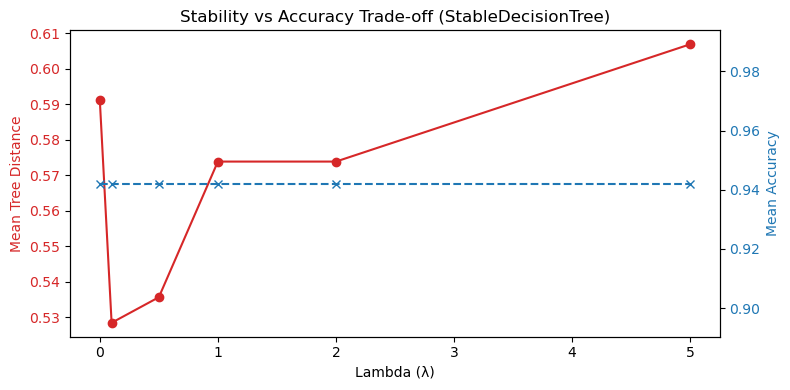

In [25]:
fig, ax1 = plt.subplots(figsize=(8, 4))

color1 = 'tab:red'
ax1.set_xlabel('Lambda (λ)')
ax1.set_ylabel('Mean Tree Distance', color=color1)
ax1.plot(df['lambda'], df['mean_distance'], color=color1, marker='o', label='Stability (↓)')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:blue'
ax2.set_ylabel('Mean Accuracy', color=color2)
ax2.plot(df['lambda'], df['mean_accuracy'], color=color2, marker='x', linestyle='--', label='Accuracy (↔)')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title("Stability vs Accuracy Trade-off (StableDecisionTree)")
fig.tight_layout()
plt.show()


# Visual_ Comparison

<Figure size 3000x1200 with 0 Axes>

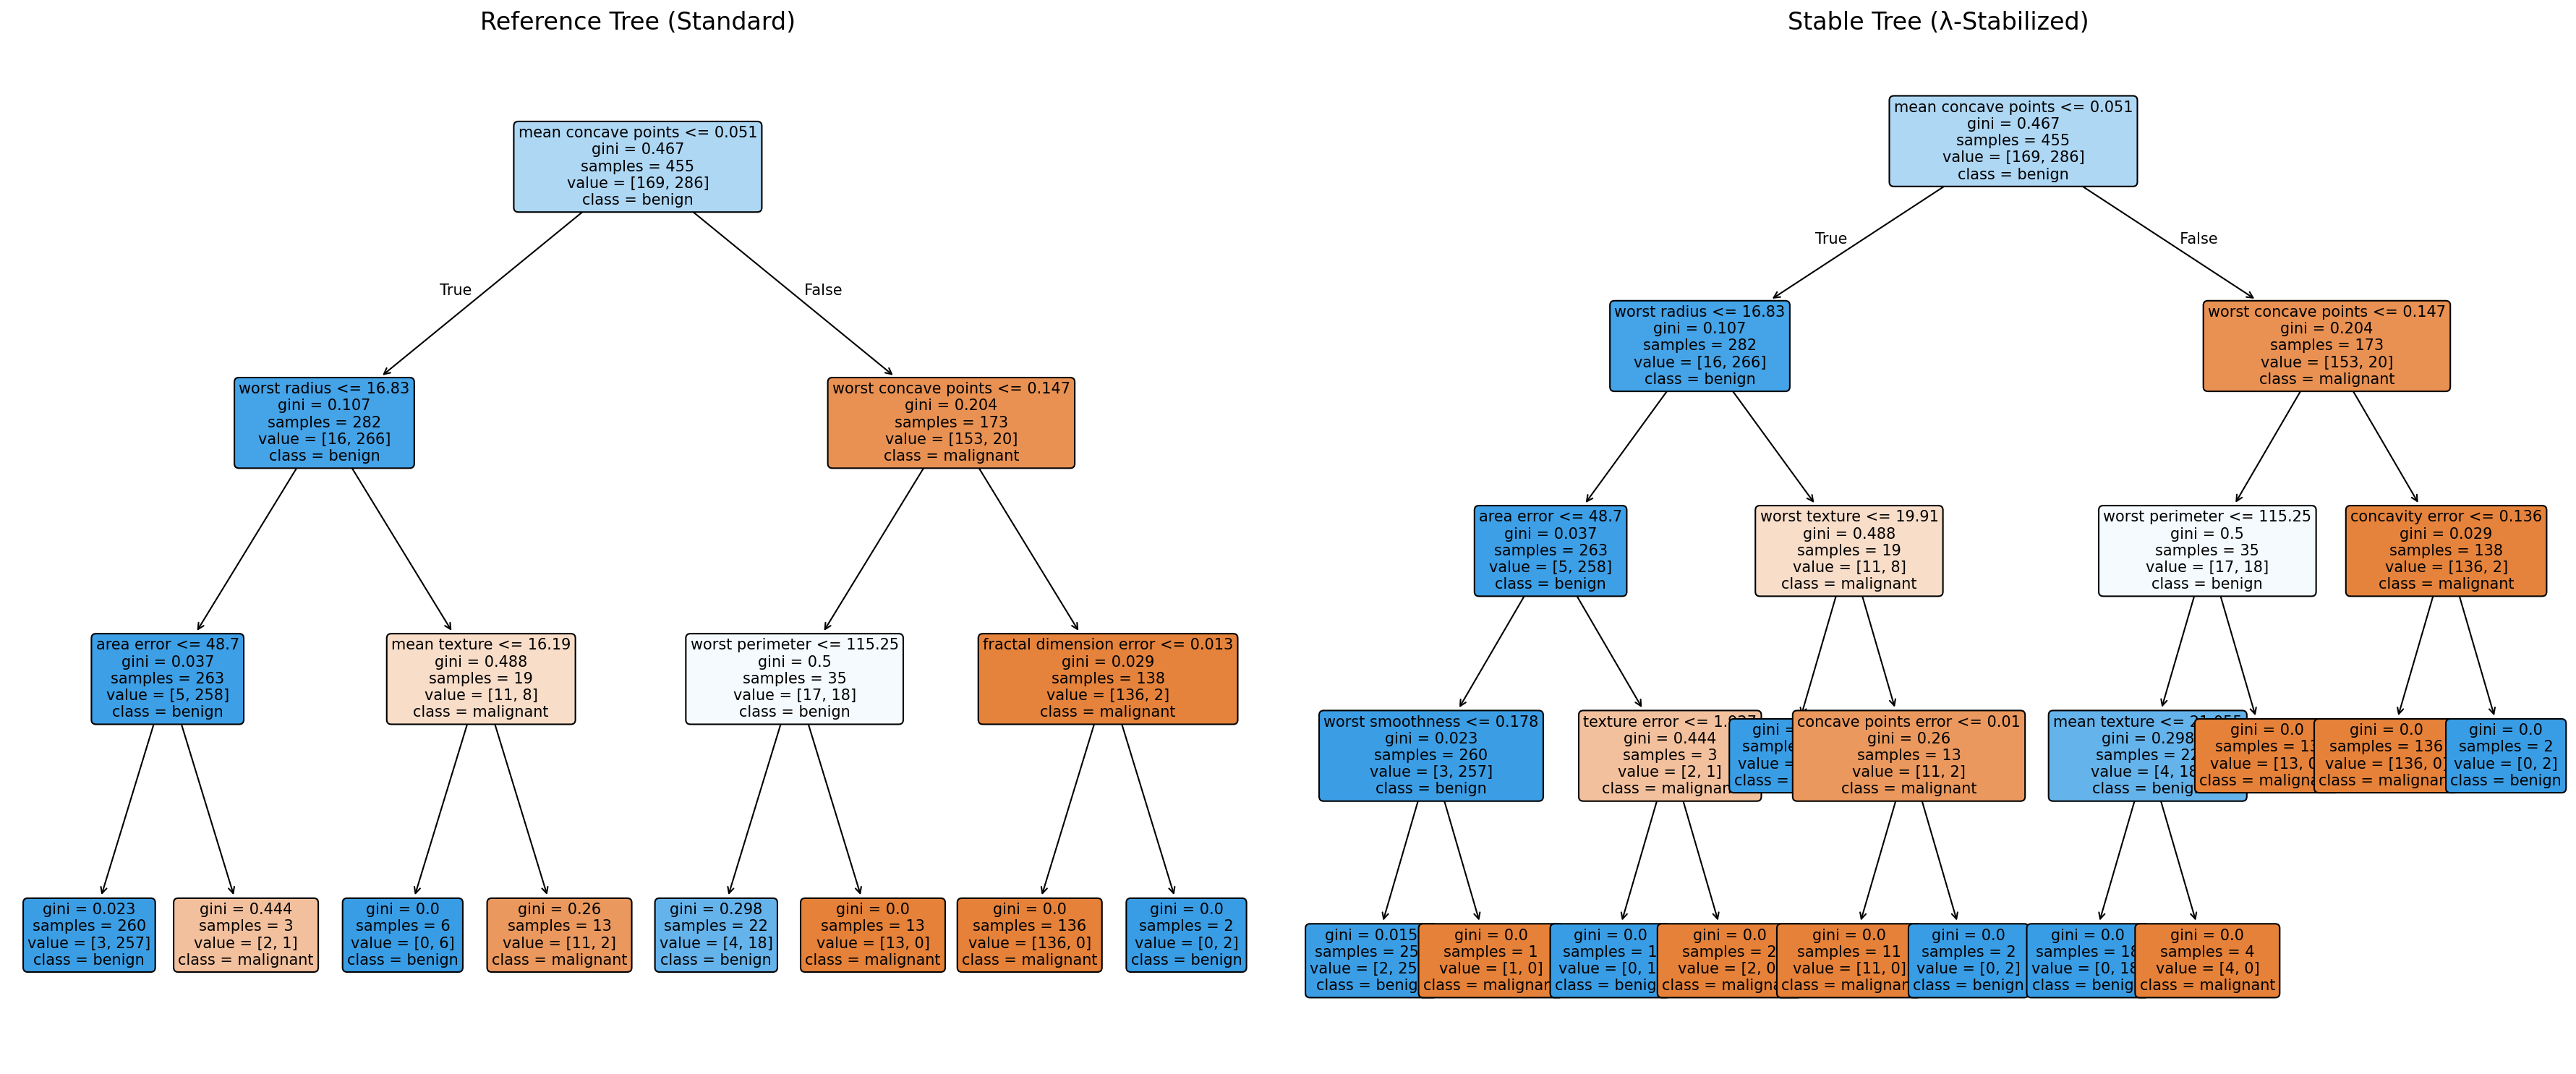

In [26]:
plt.figure(figsize=(20, 8), dpi=150)

fig, axes = plt.subplots(1, 2, figsize=(24, 10), dpi=150)

# Reference Tree
plot_tree(
    reference_model,  
    feature_names=data.feature_names,  
    class_names=data.target_names,
    filled=True,
    rounded=True,
    fontsize=10,
    ax=axes[0]
)
axes[0].set_title("Reference Tree (Standard)", fontsize=16)

# Stable Tree
plot_tree(
    stable_model.stable_tree,
    feature_names=data.feature_names,
    class_names=data.target_names,
    filled=True,
    rounded=True,
    fontsize=10,
    ax=axes[1]
)
axes[1].set_title("Stable Tree (λ-Stabilized)", fontsize=16)

plt.tight_layout()
plt.savefig("../results/tree_comparison.png", bbox_inches='tight')  # Optional: save to file
plt.show()

# Conclusion:

*In this study, we implemented a lightweight but research-grade system for evaluating stability in decision trees. Using a custom StableDecisionTree class and a structural distance metric, we quantified how trees change under slight data perturbations. Our results show that while reference and stable trees often agree on key splits (like the root node), subtree variability still occurs — highlighting the trade-off between accuracy and structural consistency. As we increase λ, the stability improves numerically, and visual comparisons confirm more consistent structure in major branches.*